In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import scipy
Image.MAX_IMAGE_PIXELS = None

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Veri seti klasörünün yolu (Data klasörünüzün yolu)
data_dir = Path('Train')
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images, train_size=0.8, shuffle=True, random_state=1)

# Yeni Bölüm

In [ ]:
# Requariments
# pip install numpy,pandas,seaborn,matlpot,path,tensorflow
# pip install scikit-learn
# $conda install -c conda-forge tensorflow


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
) # %70 eğitim datası içinden ön eğitim kontrölü içinde %20 yani 140 adet ön test (daha önceden gördüğü veri üzerinden test yapmak için) veri ayırıyoruz

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(  # verilerine kırpma, çevirme, zoom vb işlemler için oluşturulmuş kütüphane
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 18246 validated image filenames belonging to 4 classes.
Found 4561 validated image filenames belonging to 4 classes.
Found 5702 validated image filenames belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224,224,3), # resimde 3 girişli bir kanal (ağ) yapısı vardır standart ölçü
                    include_top=False,# katmanın başlangıç noktası (en üst kısmıdır) veri kalitesi ve eğitim açısından eklenmez bu yüzden False ise eklenmeyecek ise tanımlamak zorundayız
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Örneğin, 0.5 olasılıkla Dropout uygula

#x = tf.keras.layers.Dropout(0.3)(x)  # Örneğin, 0.5 olasılıkla Dropout uygula
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # 4 sınıf sayısıdır softmax (sigmoid ile arasındaki farka bakılacak)
model = tf.keras.Model(inputs, outputs)



In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)
history = model.fit(train_images,validation_data=val_images,epochs=20,batch_size =32,callbacks=[callbacks])
# İdeal değer aralıkları 1000 veri seti için düşük epoch yüksek patience değeridir  ve val_loss izlenmelidir


Epoch 1/20
571/571 [==============================] - 518s 895ms/step - loss: 1.1830 - accuracy: 0.4803 - val_loss: 1.1741 - val_accuracy: 0.4986
Epoch 2/20
571/571 [==============================] - 377s 660ms/step - loss: 1.0491 - accuracy: 0.5609 - val_loss: 0.9937 - val_accuracy: 0.5808
Epoch 3/20
571/571 [==============================] - 232s 407ms/step - loss: 1.0064 - accuracy: 0.5794 - val_loss: 0.9499 - val_accuracy: 0.6003
Epoch 4/20
571/571 [==============================] - 216s 379ms/step - loss: 0.9628 - accuracy: 0.5979 - val_loss: 0.9645 - val_accuracy: 0.6003
Epoch 5/20
571/571 [==============================] - 218s 382ms/step - loss: 0.9353 - accuracy: 0.6154 - val_loss: 0.9110 - val_accuracy: 0.6200
Epoch 6/20
571/571 [==============================] - 219s 384ms/step - loss: 0.9260 - accuracy: 0.6179 - val_loss: 0.8974 - val_accuracy: 0.6196
Epoch 7/20
571/571 [==============================] - 219s 383ms/step - loss: 0.9040 - accuracy: 0.6309 - val_loss: 0.8718 -

In [ ]:
# Eğitim kaybını al
training_loss = history.history['loss'][-1]

# Modelin performansını ve eğitim kaybını değerlendir
print(f'Training Loss: {training_loss}')

# Öğrenme Oranı Artırma:

Eğer kayıp hızlı bir şekilde azalıyorsa, öğrenme oranını artırabilirsiniz.
Eğer kayıp çok yavaş veya hızlı dalgalanıyorsa, öğrenme oranını düşürebilirsiniz.

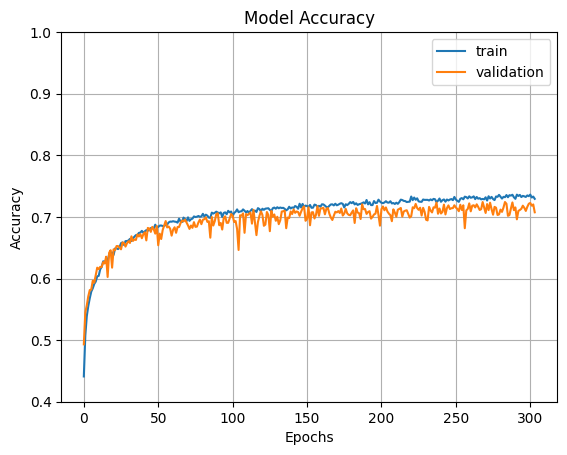

In [ ]:

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
#plt.savefig("Confusion-Matrix-Softmax/Model-Accuracy/Val_Accury.png",dpi=200)
plt.show()


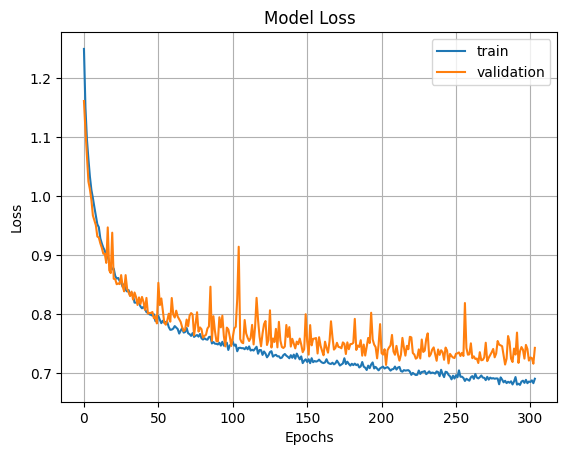

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
#plt.savefig("Confusion-Matrix-Softmax/Model-Accuracy/Val_Loss.png",dpi=200)
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.7170789837837219, 0.7243072390556335]
Test Accuracy: 72.43%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

179/179 [==============================] - 25s 130ms/step


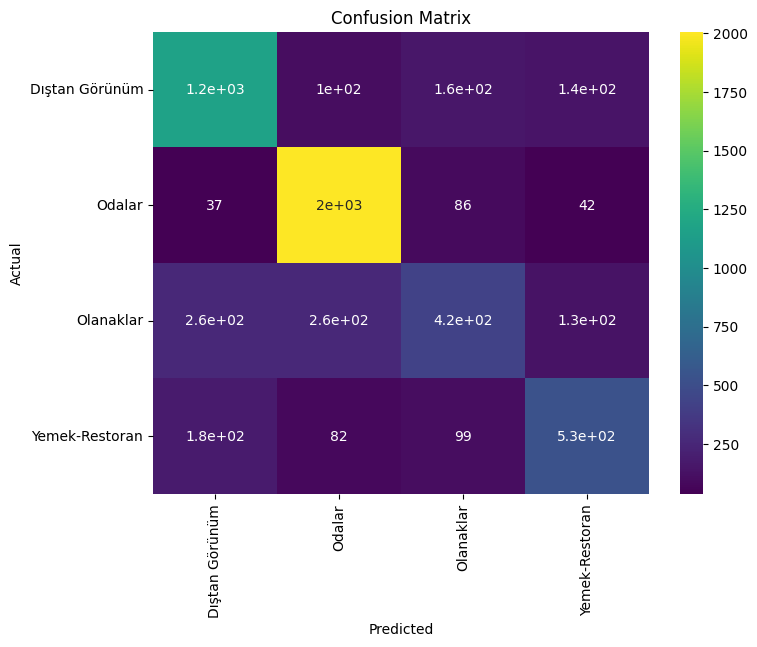

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices.keys(), rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices.keys(), rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#fig.savefig("Confusion-Matrix-Softmax/Confusion Matrix_Softmax_Dropout_02.png",dpi=200)

179/179 [==============================] - 24s 133ms/step


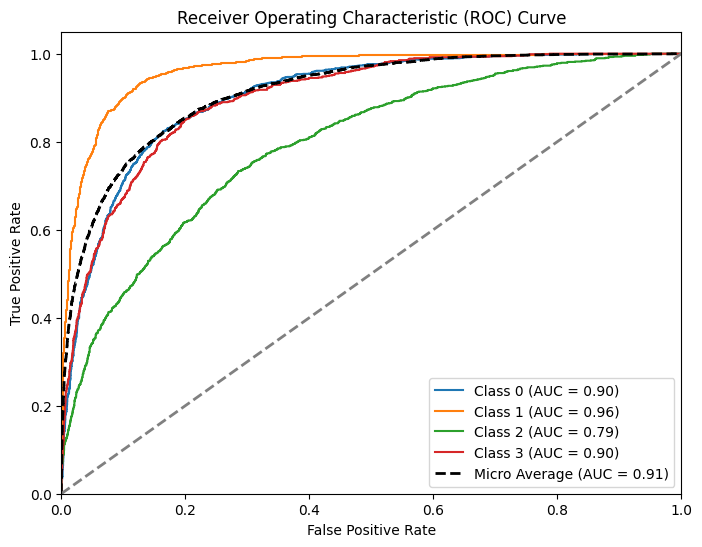

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Modelinizden tahminler yapın
predictions = model.predict(test_images)

# Etiketleri ikili forma çevirin (one-hot encoding)
test_labels_bin = label_binarize(test_images.labels, classes=[0, 1, 2, 3])

# ROC eğrisini çıkarmak için One-vs-Rest sınıflandırıcı kullanın
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_images.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro average ROC curve ve ROC alanını hesaplayın
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC eğrisini çizin
plt.figure(figsize=(8, 6))

for i in range(len(test_images.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro Average (AUC = {roc_auc["micro"]:.2f})', linestyle='--', linewidth=2, color='black')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.savefig("Confusion-Matrix-Softmax/Model-Accuracy/ROC.png",dpi=200)
plt.show()


179/179 [==============================] - 23s 128ms/step


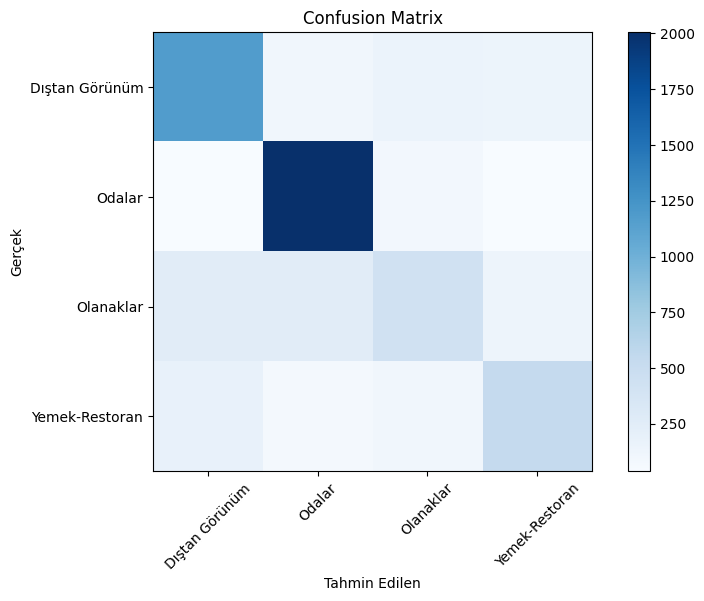

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Modelinizden tahminler yapın
predictions = model.predict(test_images)

# Etiketleri ikili forma çevirin (one-hot encoding)
test_labels_bin = label_binarize(test_images.labels, classes=[0, 1, 2, 3])

# ROC eğrisini çıkarmak için One-vs-Rest sınıflandırıcı kullanın
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_images.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro average ROC curve ve ROC alanını hesaplayın
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC Curve ve Confusion Matrix'i aynı grafikte göster
plt.figure(figsize=(16, 6))


# Confusion Matrix
plt.subplot(1, 2, 1)

# Örnek confusion matrix
cm = confusion_matrix(test_images.labels, np.argmax(predictions, axis=1))

# Görselleştirme
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_images.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.tight_layout()
#plt.savefig("Confusion-Matrix-Softmax/Model-Accuracy/Confusion Matrix.png",dpi=200)

plt.show()


179/179 [==============================] - 23s 129ms/step


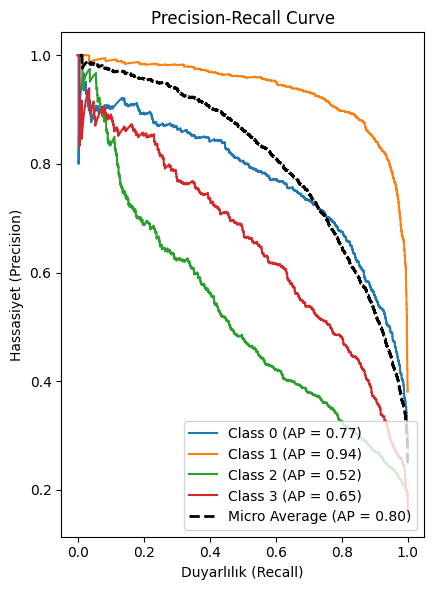

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Modelinizden tahminler yapın
predictions = model.predict(test_images)

# Etiketleri ikili forma çevirin (one-hot encoding)
test_labels_bin = label_binarize(test_images.labels, classes=[0, 1, 2, 3])

# Precision-Recall Curve'ü çıkarmak için One-vs-Rest sınıflandırıcı kullanın
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(test_images.class_indices)):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(test_labels_bin[:, i], predictions[:, i])

# Micro average Precision-Recall curve ve Precision alanını hesaplayın
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels_bin.ravel(), predictions.ravel())
average_precision["micro"] = average_precision_score(test_labels_bin, predictions, average="micro")

# Precision-Recall Curve,  grafikte göster
plt.figure(figsize=(12, 6))

# Precision-Recall Curve
plt.subplot(1, 3, 1)

for i in range(len(test_images.class_indices)):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.plot(recall["micro"], precision["micro"], label=f'Micro Average (AP = {average_precision["micro"]:.2f})', linestyle='--', linewidth=2, color='black')

plt.xlabel('Duyarlılık (Recall)')
plt.ylabel('Hassasiyet (Precision)')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.savefig("Confusion-Matrix-Softmax/Model-Accuracy/Precision-Recall Curve.png",dpi=200)

plt.tight_layout()
plt.show()


In [ ]:
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

Dıştan Görünüm       0.71      0.74      0.73      1573
        Odalar       0.82      0.92      0.87      2170
     Olanaklar       0.55      0.40      0.46      1069
Yemek-Restoran       0.63      0.60      0.61       890

      accuracy                           0.72      5702
     macro avg       0.68      0.67      0.67      5702
  weighted avg       0.71      0.72      0.71      5702



In [ ]:
data_his = pd.DataFrame(history.history)
train_images.class_indices.keys()
train_images.class_indices.values()
df=pd.DataFrame({'names':list(train_images.class_indices.keys()),
                 'index':list(train_images.class_indices.values())})
df.iloc[0]['names']


'Dıştan Görünüm'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
model.save('Models/Softmax/ResNet_pat_100_epoch_304_Softmax_Drop.h5')

# TKINTER VIEW

In [ ]:
# Veri Setinin tamamını test işlemini veriyoruz ve tahmin ettiği sonuçları yeni bir file dosyasına yazıyoruz ki daha sonraki zamanda eğitim için kullanabiliriz

import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import shutil, sys
model = load_model('Models/Softmax/ResNet_pat_100_epoch_304_Softmax_Drop.h5')
classes = {
    0:'Dıştan Görünüm',
    1:'Odalar',
    2:'Olanaklar',
    3:'Yemek-Restoran'
}
#dir_path = 'image/b' # Sistemde testleri consolda olmasını istediğimizde yolu belirtiyoruz

top=tk.Tk()
top.geometry('800x600')
top.title('Deep Learning')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((224,224))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    pred=np.argmax(model.predict([image])[0],axis=-1)
    sign = classes[pred]

     # Hedef sınıf klasörünü oluştur
    class_folder = os.path.join(output_folder, sign)
    os.makedirs(class_folder, exist_ok=True)

    # Resmi taşı ve yeniden adlandır
    file_name = os.path.basename(file_path)
    new_file_name = f"{sign}_{len(os.listdir(class_folder)) + 1}.jpg"
    new_file_path = os.path.join(class_folder, new_file_name)
    shutil.copy(file_path, new_file_path)
    print(pred)
    label.configure(foreground='#011638', text=sign)
def show_classify_button(file_path):
    classify_b=Button(top,text="Sınıflandır",
    command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload=Button(top,text="Yükle",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Deep Learning Projesi",pady=20, font=('arial',20,'bold'))

heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()


if __name__ == "__main__":
    output_folder = 'output_server'  # Sınıflandırılan resimlerin taşınacağı klasör
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)


1/1 [==============================] - 1s 840ms/step
1
1/1 [==============================] - 0s 62ms/step
1
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 47ms/step
2


from tensorflow.keras.preprocessing import image
dir_path = 'test'

for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'/'+i,target_size=(650,650))
    plt.imshow(img)
    plt.show()
    
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis=0)
    images = np.vstack([X])
    predictions = np.argmax(model.predict(images), axis=1)
    print(df.iloc[predictions]['names'])